In [46]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score, f1_score

In [47]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [48]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [49]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

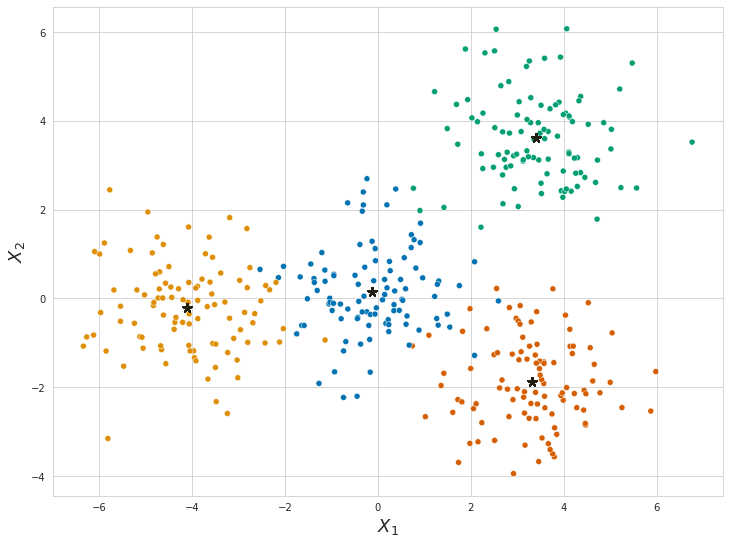

In [50]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [51]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import adjusted_rand_score

In [52]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)  
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        return euclidean_distances(X, centroid.reshape(1, -1))
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

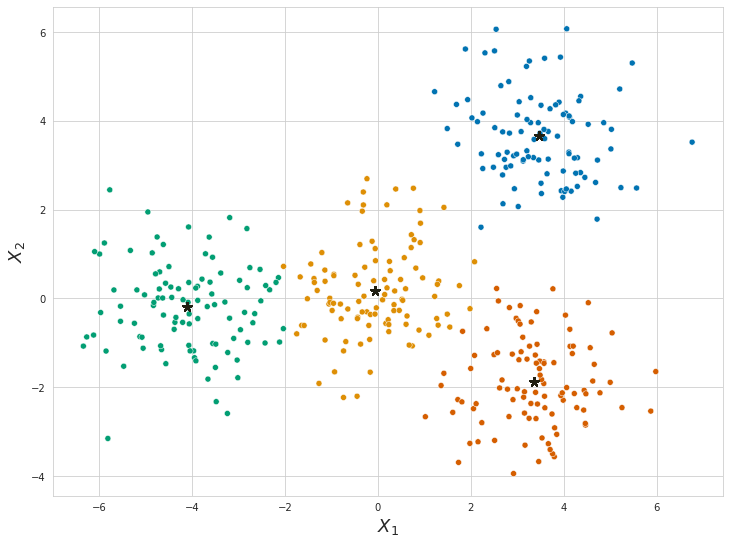

Коэффициент силуэта(хорошо разделили = 1; плохо = -1; кластеры перекрываются = 0): 0.56431, 
Индекс Рэнда (две кластеризации вовсе не согласуются = 0; кластеризации одинаковы = 1): 0.92787


In [53]:
KM_model = MyKMeans(4, init="random", visualize=True, max_iter=7)
KM_model.fit(X)

pred_lbls = KM_model.predict(X)

print(f'Коэффициент силуэта(хорошо разделили = 1; плохо = -1; кластеры перекрываются = 0): \
{round(silhouette_score(X, pred_lbls), 5)}, \
\nИндекс Рэнда (две кластеризации вовсе не согласуются = 0; кластеризации одинаковы = 1): \
{round(adjusted_rand_score(true_labels, pred_lbls), 5)}')

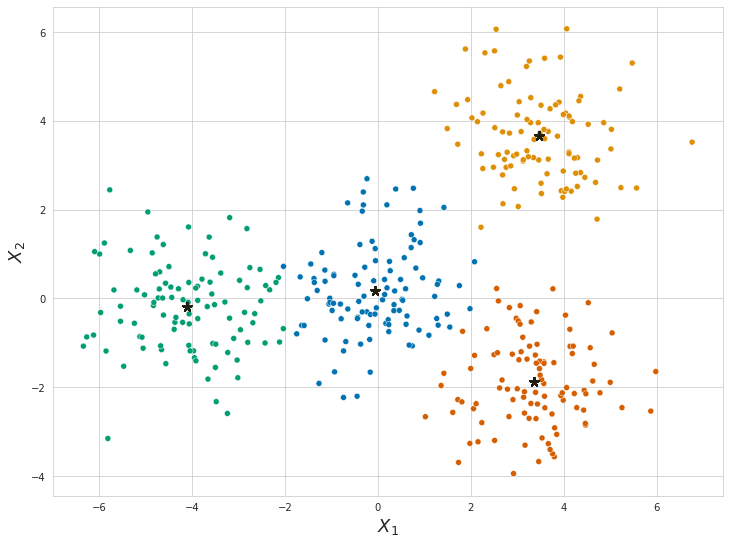

Коэффициент силуэта(хорошо разделили = 1; плохо = -1; кластеры перекрываются = 0): 0.56431, 
Индекс Рэнда (две кластеризации вовсе не согласуются = 0; кластеризации одинаковы = 1): 0.92787


In [54]:
KM_model = MyKMeans(4, init="sample", visualize=True, max_iter=7)
KM_model.fit(X)

pred_lbls = KM_model.predict(X)

print(f'Коэффициент силуэта(хорошо разделили = 1; плохо = -1; кластеры перекрываются = 0): \
{round(silhouette_score(X, pred_lbls), 5)}, \
\nИндекс Рэнда (две кластеризации вовсе не согласуются = 0; кластеризации одинаковы = 1): \
{round(adjusted_rand_score(true_labels, pred_lbls), 5)}')

*Результаты неплохие в обоих случаях, но инициализации центроидов с параметром 'random' (генерирует координаты случайно из нормального распределения) оказалась немного удачнее, чем с 'sample' (выбирает центроиды случайно из объектов выборки)*

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [55]:
data = load_digits()
X, y = data.data, data.target

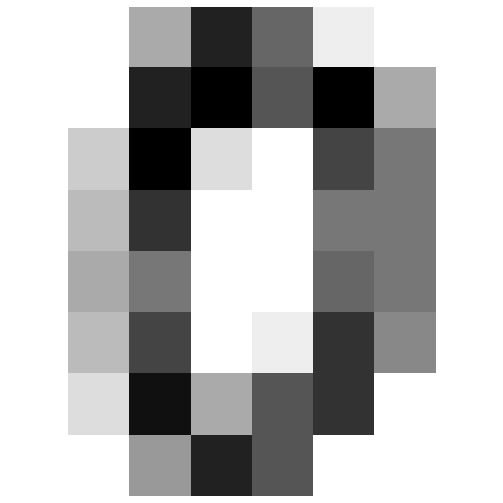

In [56]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray_r")
plt.axis("off");

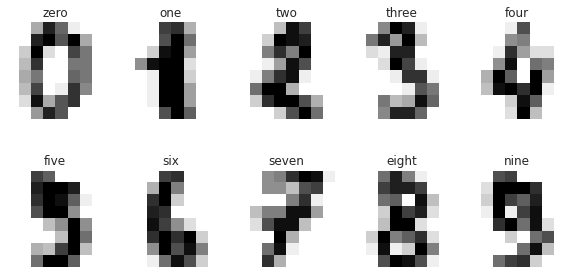

In [57]:
labels = {0:'zero', 1:'one', 2:'two', 3: 'three', 4: 'four', 
          5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}
y = y.astype(int) # make an integer array
plt.figure(figsize = (10, 5))
for lb in range(10):
  plt.subplot(2,5,lb+1)
  idx = np.where(y == lb)[0][0]
  image = X[idx].reshape(8, 8)
  plt.imshow(image, cmap='gray_r')
  plt.title(labels[lb])
  plt.axis("off")

In [58]:
y_lb = np.array([labels[x] for x in y]) # make an array of lables
items = pd.DataFrame(y_lb)
items.value_counts()

three    183
five     182
one      182
four     181
six      181
nine     180
seven    179
zero     178
two      177
eight    174
dtype: int64

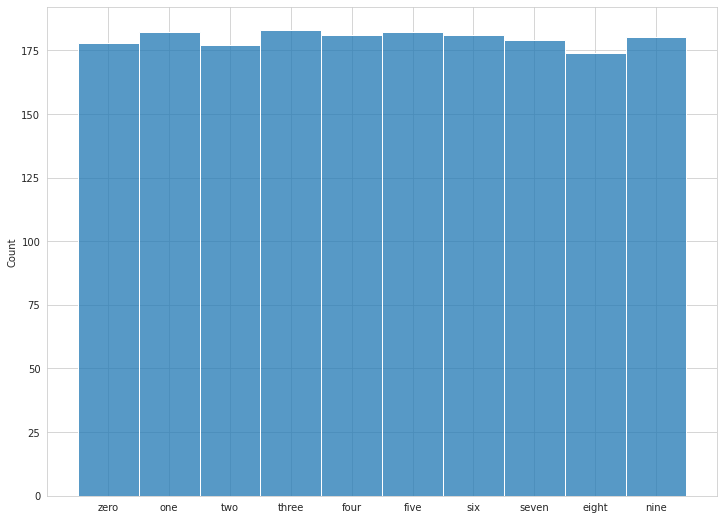

In [59]:
hist = sns.histplot(y_lb)
# распределение образцов цифр выглядит очень равномерно (классы сбалансированны)

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### Algorithm of selection

In [60]:
def algorithm_selection(X, distances, algorithms):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    cols = ['distance', 'linkage', 'homogeneity', 'completeness', 'v_measure', 'silhouette']
    compare_dataframe = pd.DataFrame(columns = cols)
    
    for dist in distances:
        for alg in algorithms:
          y_pred = AgglomerativeClustering(10, affinity=dist, linkage=alg).fit_predict(X)
          hm = homogeneity_score(y, y_pred)
          cm = completeness_score(y, y_pred)
          vm = v_measure_score(y, y_pred)
          sh = silhouette_score(X, y_pred, metric=dist)
          compare_dataframe.loc[len(compare_dataframe)] = [dist, alg, hm, cm, vm, sh]
    return compare_dataframe

In [61]:
distances = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'canberra']
algorithms = ['average', 'single', 'complete']

In [62]:
algorithm_selection(X, distances, algorithms)

,distance,linkage,homogeneity,completeness,v_measure,silhouette
0,euclidean,average,0.655393,0.782342,0.713263,0.146625
1,euclidean,single,0.005056,0.273755,0.009929,-0.133621
2,euclidean,complete,0.590549,0.637772,0.613253,0.119271
3,manhattan,average,0.566751,0.778942,0.656117,0.105238
4,manhattan,single,0.005102,0.276237,0.010019,-0.203816
5,manhattan,complete,0.646372,0.686109,0.665648,0.160617
6,cosine,average,0.648268,0.808762,0.719676,0.218229
7,cosine,single,0.005050,0.273389,0.009916,-0.281789
8,cosine,complete,0.528727,0.577415,0.551999,0.144179
9,chebyshev,average,0.769464,0.828645,0.797959,0.106666


### *Лучший алгоритм -- average, чуть хуже -- complete; лучшая метрика -- chebyshev (но толшько в сочетании с average), чуть хуже euclidean, manhattan*

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [63]:
import scipy.stats as stats

In [64]:
fc_data = pd.read_csv(join("flow_c_data.csv"), index_col=0)

In [65]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [66]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


*Для некоторых переменных (столбцов) видим большую разницу между 75-м и 25-м процентилями. Значит имеются выбросы.*

<AxesSubplot:xlabel='variable', ylabel='value'>

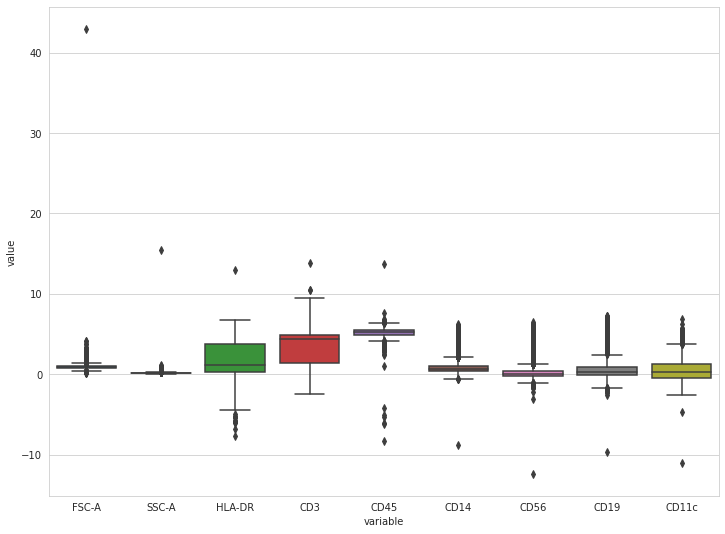

In [67]:
sns.boxplot(x="variable", y="value", data=pd.melt(fc_data))
# оценим наличие выпадающих точек на графике

*Поскольку выбросы имеются сразу в нескольких столбцах,  удаление их всех может привести к большой потере данных. Оценим степень потери при сохранении только тех образцов (строк), чьи показатели по всем измеренным параметрам лежат в пределах трёх квантилей:*

In [68]:
#find Q1, Q3, and interquartile range for each column
Q1 = fc_data.quantile(q=.25)
Q3 = fc_data.quantile(q=.75)
IQR = fc_data.apply(stats.iqr)

In [69]:
#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
fc_cleaned = fc_data[~((fc_data < (Q1- 1.5*IQR)) | (fc_data > (Q3+1.5*IQR))).any(axis=1)]
print('при интервале IQR = 3 число оставшихся строк:', fc_cleaned.shape[0], \
      'из 10000; то есть процент удалённых данных =', \
      100*(fc_data.shape[0] - fc_cleaned.shape[0]) /fc_data.shape[0])

при интервале IQR = 3 число оставшихся строк: 5581 из 10000; то есть процент удалённых данных = 44.19


*Такой метод чистки для данного датасета не подходит; его лучше "очищать" не по всем сразу, а лишь по некоторым столбцам, которые содержат наибольлее вопиющие выбросы (FSC-A, SSC-A).*

In [70]:
fc_cleaned = fc_data.drop(fc_data['FSC-A'].idxmax())

<AxesSubplot:xlabel='variable', ylabel='value'>

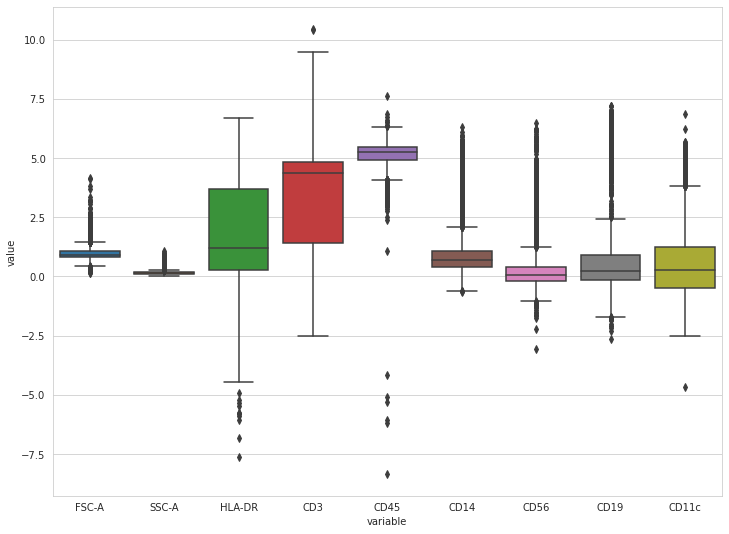

In [71]:
sns.boxplot(x="variable", y="value", data=pd.melt(fc_cleaned))
# оценим наличие выпадающих точек на графике

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [72]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

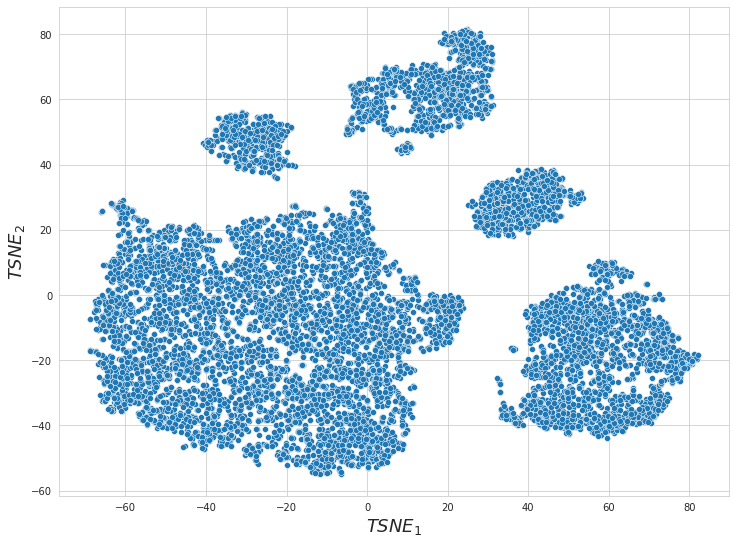

In [73]:
tsne_res = plot_tsne(fc_cleaned)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

### *K-means*

In [74]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS

*Создадим функцию отрисовки графиков кластеризации:*

In [75]:
def clust_plot(pred_lbs):
    sns.scatterplot(tsne_res[:, 0], tsne_res[:, 1], pred_lbs, palette="bright")

*Select the optimal number of clusters (as can be seen below, the best k is 4)*

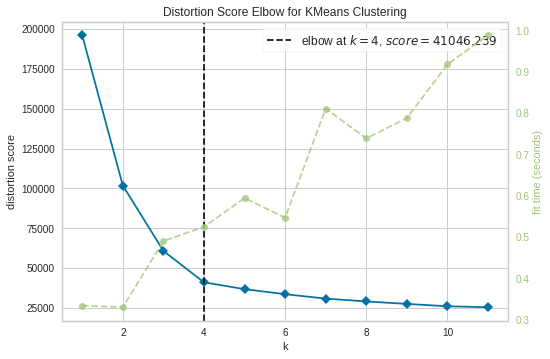

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
from yellowbrick.cluster import KElbowVisualizer
KElbowVisualizer(KMeans(), k=(1,12)).fit(fc_cleaned).show() 

*Используем "наилучшее" число кластеров = 4:*

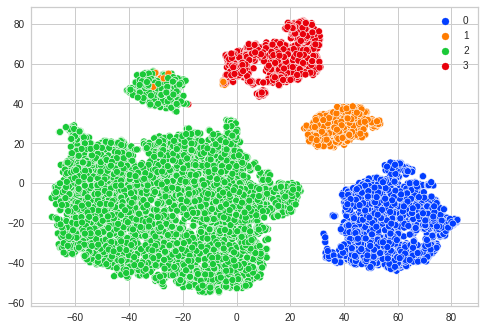

In [77]:
KM_mod4 = KMeans(4).fit_predict(fc_cleaned)
clust_plot(KM_mod4)

*Однако визуальная оценка свидетельствует в пользу пяти кластеров (а не 4). Построим график с этим значением:*

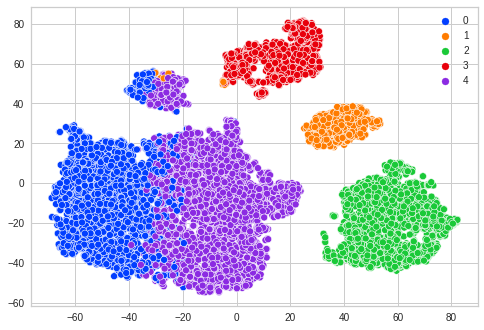

In [78]:
KM_mod5 = KMeans(5).fit_predict(fc_cleaned)
clust_plot(KM_mod5)

*Этот алгоритм кластеризует не так, как ожидалось.
Пробуем другие алгоритмы:*

### *AgglomerativeClustering*

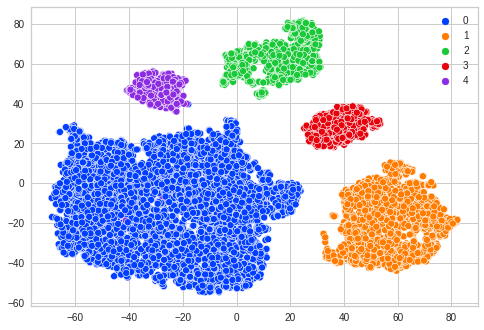

In [79]:
AgC_mod = AgglomerativeClustering(5).fit_predict(fc_cleaned)
clust_plot(AgC_mod)

*Здесь разделение выглядит более логичным*

### *DBSCAN*

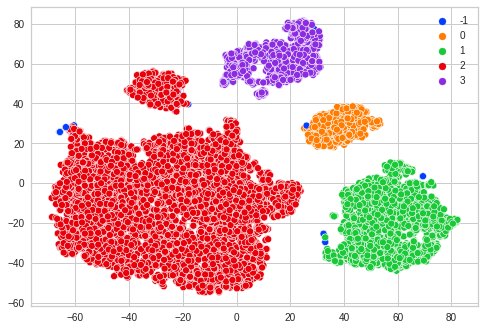

In [80]:
DBSCAN_mod = DBSCAN(eps=1.5, metric='chebyshev').fit_predict(fc_cleaned)
clust_plot(DBSCAN_mod)

*Этот алгоритм тоже выдаёт 4 кластера (пробовала разные параметры, лучше не становится)*

### *OPTICS*

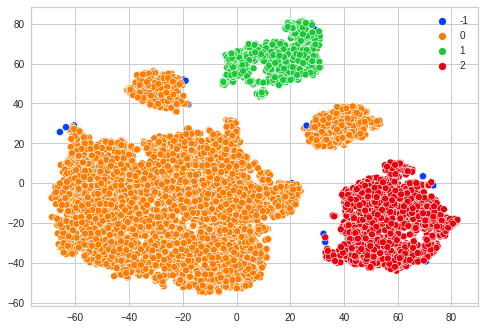

In [81]:
OPTICS_mod = OPTICS(eps=1, min_cluster_size=30).fit_predict(fc_cleaned)
clust_plot(OPTICS_mod)

*Этот метод вообще только три кластера смог выделить. Ну и в "четвёртый" отнёс всякие крайние точки со всех остальных. Не нравится*

### *Сравнение результатов (силуэта) выбранных методов:*

In [82]:
print(f'Сравнение коэффициентов силуэта при различных методах. \n(если хорошо разделили = 1; плохо = -1; кластеры перекрываются = 0) \
\nKMeans(n=4):             {round(silhouette_score(fc_cleaned, KM_mod4), 5)}, \
\nKMeans(n=5):             {round(silhouette_score(fc_cleaned, KM_mod5), 5)}, \
\nAgglomerativeClustering: {round(silhouette_score(fc_cleaned, AgC_mod), 5)}, \
\nDBSCAN:                  {round(silhouette_score(fc_cleaned, DBSCAN_mod), 5)}, \
\nOPTICS:                  {round(silhouette_score(fc_cleaned, OPTICS_mod), 5)}')

Сравнение коэффициентов силуэта при различных методах. 
(если хорошо разделили = 1; плохо = -1; кластеры перекрываются = 0) 
KMeans(n=4):             0.6111, 
KMeans(n=5):             0.35108, 
AgglomerativeClustering: 0.46369, 
DBSCAN:                  0.61283, 
OPTICS:                  0.60963


Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

*Да, такую кластеризацию предложил AgglomerativeClustering с параметром "число кластеров = 5". При этом он получил очень низкий балл силуэта (хуже только у KMeans, n=5). Другие протестированные способы кластеризации показывают примерно одинаковый, неплохой силуэт (ок. 0,6), но очевидно неудачное распределение (например, всего три кластера выдал OPTICS, "окрасив одним цветом" явно отстоящие друг от друга три группы точек)*

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

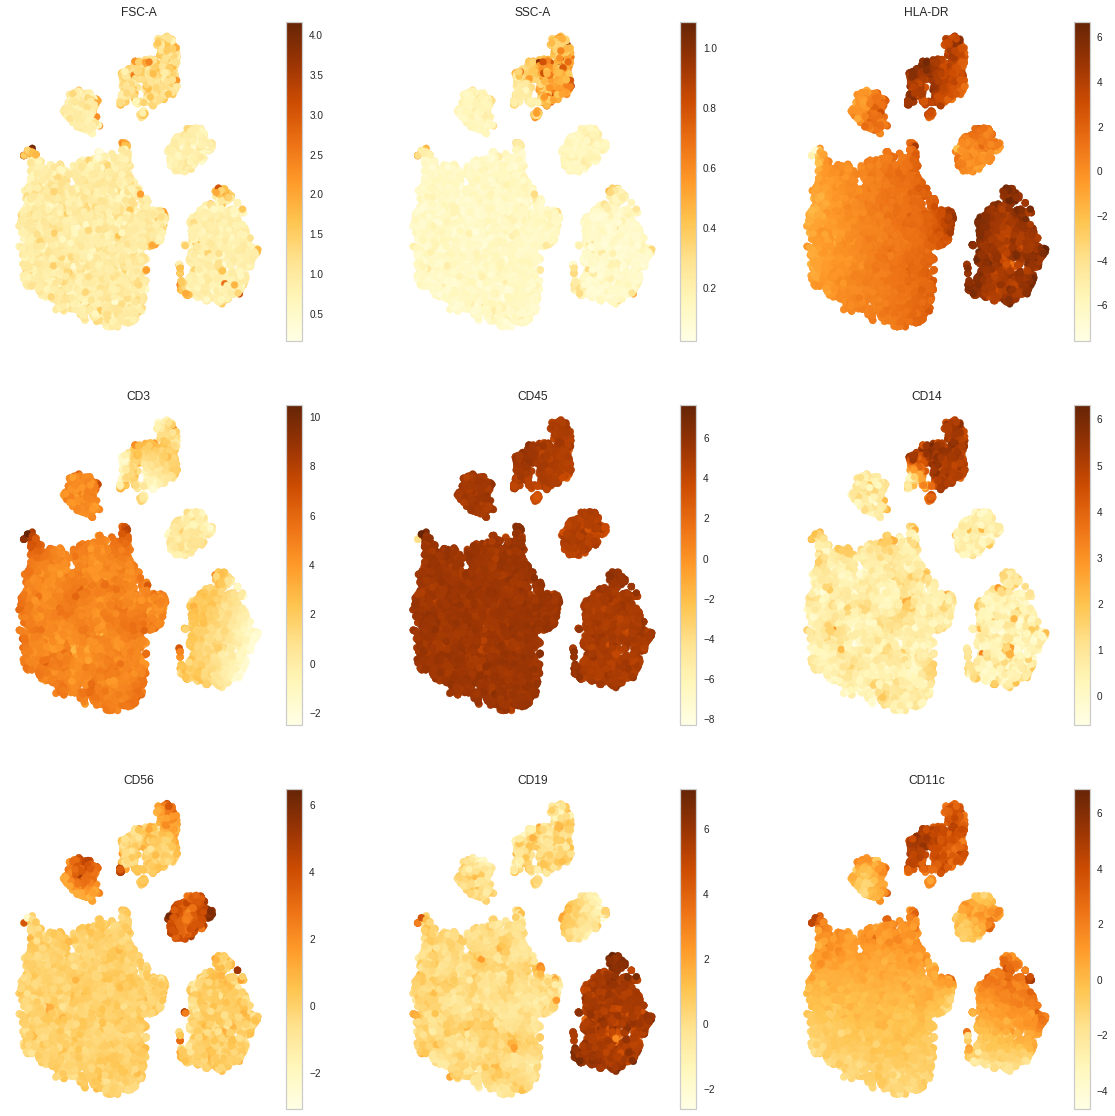

In [83]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_cleaned.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_cleaned[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

### *Наиболее заметные отличия между кластерами показаны для экспрессии маркеров:*

* CD3	(an important T-cell marker)
* CD14	(monocytes)
* CD19 (biomarker for B-cell)

In [84]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "B_cells", 
                         2: "Monocytes", 
                         3: "Other cells",
                         4: "Other cells"}

In [85]:
AgC_mod_fit = AgglomerativeClustering(5).fit(fc_cleaned)

In [86]:
labeled_fc_data = fc_cleaned.assign(Population=AgC_mod_fit.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [87]:
labeled_fc_data.Population.value_counts()

T_cells        5768
B_cells        2035
Monocytes      1099
Other cells    1097
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [88]:
labeled_fc_data.to_csv('AgglomerativeClust_labels.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

*Применю Random forest*

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [90]:
X = labeled_fc_data.drop('Population', axis=1)
y = labeled_fc_data[['Population']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# сбалансируем данные
scale_It = StandardScaler() # Centering and scaling
X_train = scale_It.fit_transform(X_train)
X_test = scale_It.transform(X_test)

In [91]:
# буду использовать DecisionTreeClassifier классификатор
params = {'criterion': ['gini', 'entropy', 'log_loss'], # выбираю его параметры
          'max_depth': range(1, 30, 3)}

clf = GridSearchCV(DecisionTreeClassifier(), params, cv = 5)
clf.fit(X_train, y_train)

print(f'f score: {clf.best_score_} \
\nнаилучшие параметры: {clf.best_params_}')

f score: 0.9968746091307066 
наилучшие параметры: {'criterion': 'log_loss', 'max_depth': 19}


### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Сад гортензий Мичиноку в Японии. Но не этой весной =(

![picture](https://drive.google.com/uc?export=view&id=1-iYq-QWk0KIi_4UM6MWqQQkXppntJHzj)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**